In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import keras

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold

c:\Users\User\anaconda3\envs\hsenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data Preprocessing and Labeling

In [2]:
video_directory = 'Latest-WLASL-100'

sum = 0

gesture_folder = np.array(os.listdir(video_directory))
for gestures in gesture_folder:
    gesture = []

    for fname in os.listdir(os.path.join(video_directory, gestures)):
        path = os.path.join(video_directory, gestures, fname)
        if os.path.isdir(path):
            gesture.append(fname)

    sum += len(gesture) 
    # print(gestures, end =" : ")        
    # print(len(gesture))

print("Total gestures: ", len(gesture_folder), "; Total videos: ", sum)

Total gestures:  100 ; Total videos:  2874


In [3]:
print(gesture_folder)

['accident' 'africa' 'all' 'apple' 'basketball' 'bed' 'before' 'bird'
 'birthday' 'black' 'blue' 'book' 'bowling' 'brown' 'but' 'can' 'candy'
 'chair' 'change' 'cheat' 'city' 'clothes' 'color' 'computer' 'cook'
 'cool' 'corn' 'cousin' 'cow' 'dance' 'dark' 'deaf' 'decide' 'doctor'
 'dog' 'drink' 'eat' 'enjoy' 'family' 'fine' 'finish' 'fish' 'forget'
 'full' 'give' 'go' 'graduate' 'hat' 'hearing' 'help' 'hot' 'how' 'jacket'
 'kiss' 'language' 'last' 'later' 'letter' 'like' 'man' 'many' 'medicine'
 'meet' 'mother' 'need' 'no' 'now' 'orange' 'paint' 'paper' 'pink' 'pizza'
 'play' 'pull' 'purple' 'right' 'same' 'school' 'secretary' 'shirt'
 'short' 'son' 'study' 'table' 'tall' 'tell' 'thanksgiving' 'thin'
 'thursday' 'time' 'walk' 'want' 'what' 'white' 'who' 'woman' 'work'
 'wrong' 'year' 'yes']


In [4]:
label_map = {label: num for num, label in enumerate(gesture_folder)}
len(label_map)

100

Sort first

In [5]:
gesture_sequence, labels = [], []

for gesture_name in gesture_folder:  # e.g., 'about'
    gesture_instances = []

    # List directories inside the gesture folder
    gesture_path = os.path.join(video_directory, gesture_name)
    for instance in os.listdir(gesture_path):
        print("Instance:", instance)
        instance_path = os.path.join(gesture_path, instance)
        if os.path.isdir(instance_path):
            # Check for the extra subfolder 'interpolated_landmarks'
            landmarks_path = os.path.join(instance_path, 'interpolated_landmarks')
            if os.path.isdir(landmarks_path):
                gesture_instances.append(landmarks_path)
            else:
                gesture_instances.append(instance_path)

    for load_path in gesture_instances:
        npy_files = [f for f in os.listdir(load_path) if f.endswith('.npy')]
        # Sort files by extracting and converting the numeric part of the filename
        npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        print("Sorted .npy files in", load_path, ":", npy_files)

        video = []
        for npy in npy_files:
            video.append(np.load(os.path.join(load_path, npy)))
        
        # Optionally check if video is not empty before appending
        if video:
            gesture_sequence.append(video)
            labels.append(label_map[gesture_name])
        else:
            print(f"Warning: No .npy files found in {load_path}")

X = np.array(gesture_sequence)
y = np.array(labels)

np.save('X_TRAIN_B.npy', X)
np.save('y_TRAIN_B.npy', y)

print("X shape:", X.shape)
print("y shape:", y.shape)


Instance: 1
Instance: 1.mp4
Instance: 10
Instance: 10.mp4
Instance: 11
Instance: 11.mp4
Instance: 12
Instance: 12.mp4
Instance: 13
Instance: 13.mp4
Instance: 14
Instance: 14.mp4
Instance: 2
Instance: 2.mp4
Instance: 3
Instance: 3.mp4
Instance: 4
Instance: 4.mp4
Instance: 5
Instance: 5.mp4
Instance: 6
Instance: 6.mp4
Instance: 7
Instance: 7.mp4
Instance: 8
Instance: 8.mp4
Instance: 9
Instance: 9.mp4
Sorted .npy files in WLASL-100\accident\1\interpolated_landmarks : ['1.npy', '2.npy', '3.npy', '4.npy', '5.npy', '6.npy', '7.npy', '8.npy', '9.npy', '10.npy', '11.npy', '12.npy', '13.npy', '14.npy', '15.npy', '16.npy', '17.npy', '18.npy', '19.npy', '20.npy', '21.npy', '22.npy', '23.npy', '24.npy', '25.npy', '26.npy', '27.npy', '28.npy', '29.npy', '30.npy']
Sorted .npy files in WLASL-100\accident\10\interpolated_landmarks : ['1.npy', '2.npy', '3.npy', '4.npy', '5.npy', '6.npy', '7.npy', '8.npy', '9.npy', '10.npy', '11.npy', '12.npy', '13.npy', '14.npy', '15.npy', '16.npy', '17.npy', '18.npy',

In [6]:
# %%script false --no-raise-error
gesture_sequence, labels = [], []

for gestures in gesture_folder:
    gesture = []

    for fname in os.listdir(os.path.join(video_directory, gestures)):
        path = os.path.join(video_directory, gestures, fname)
        if os.path.isdir(path):
            gesture.append(fname)

    for no in gesture:
        load_path = os.path.join(video_directory, gestures, no)
        npy_files = sorted([f for f in os.listdir(load_path) if f.endswith('.npy')])
        npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

        video = []
        for npy in npy_files:
            video.append(np.load(os.path.join(load_path, npy)))
        
        gesture_sequence.append(video)
        labels.append(label_map[gestures])

    # print(np.array(gesture_sequence).shape, np.array(labels).shape)

X = np.array(gesture_sequence)
y = np.array(labels)

np.save('train_numpy/train_3/X_TRAIN_3.npy', X)
np.save('train_numpy/train_3/y_TRAIN_3.npy', y)

In [2]:
X = np.load('X_TRAIN_normalized.npy')
y = np.load('y_TRAIN_normalized.npy')

print(X.shape, y.shape)

(2038, 512, 258) (2038,)


In [6]:
y = tf.keras.utils.to_categorical(y, num_classes=len(gesture_folder))
y.shape

(2038, 100)

In [7]:
y_labels = np.argmax(y, axis=1)

##### Random stratified Train_test_split

In [8]:
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X, y, test_size=0.2, stratify=y_labels, random_state=42)

In [9]:
X_test_ori, X_val_ori, y_test_ori, y_val_ori = train_test_split(
    X_test_ori, y_test_ori, test_size=0.5, stratify=y_test_ori.argmax(axis=1), random_state=42)

In [10]:
y_train_ori.shape, y_test_ori.shape, y_val_ori.shape

((1630, 100), (204, 100), (204, 100))

In [11]:
if torch.cuda.is_available():
    print("GPU is available!")
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

GPU is available!
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 3050


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Train

In [13]:
# %%script false
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_ori, dtype=torch.float32)
X_test = torch.tensor(X_test_ori, dtype=torch.float32)
y_train = torch.tensor(y_train_ori.argmax(axis=1), dtype=torch.long)  # Convert to class indices
y_test = torch.tensor(y_test_ori.argmax(axis=1), dtype=torch.long)  # Convert to class indices
X_val = torch.tensor(X_val_ori, dtype=torch.float32)
y_val = torch.tensor(y_val_ori.argmax(axis=1), dtype=torch.long)

# Create DataLoader for training data
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# Create DataLoader for validation data
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)

# Define your custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_size = 258
hidden_size = 64
num_classes = len(label_map)
model = CustomLSTM(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model with early stopping
num_epochs = 10000
loss_history = []
val_loss_history = []

# loss threshold
loss_threshold = 0.1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        # Move batch to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item() # Accumulate loss

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            val_loss += loss.item()  # Accumulate validation loss

            # Compute accuracy
            predictions = outputs.argmax(dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    val_accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if avg_loss < loss_threshold:
        print(f'Loss threshold of {loss_threshold} reached. Stopping training.')
        break

# Evaluate the model
model.eval()
with torch.no_grad():
    # Move test data to GPU
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    accuracy = (test_outputs.argmax(dim=1) == y_test).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')

Epoch [1/10000], Loss: 4.6115, Val Loss: 4.6058, Val Accuracy: 0.0147
Epoch [2/10000], Loss: 4.6085, Val Loss: 4.6037, Val Accuracy: 0.0147
Epoch [3/10000], Loss: 4.6059, Val Loss: 4.6017, Val Accuracy: 0.0147
Epoch [4/10000], Loss: 4.6040, Val Loss: 4.5989, Val Accuracy: 0.0196
Epoch [5/10000], Loss: 4.6025, Val Loss: 4.5979, Val Accuracy: 0.0196
Epoch [6/10000], Loss: 4.6012, Val Loss: 4.5962, Val Accuracy: 0.0196
Epoch [7/10000], Loss: 4.5997, Val Loss: 4.5954, Val Accuracy: 0.0196
Epoch [8/10000], Loss: 4.5988, Val Loss: 4.5949, Val Accuracy: 0.0196
Epoch [9/10000], Loss: 4.5981, Val Loss: 4.5941, Val Accuracy: 0.0196
Epoch [10/10000], Loss: 4.5980, Val Loss: 4.5938, Val Accuracy: 0.0196
Epoch [11/10000], Loss: 4.5975, Val Loss: 4.5928, Val Accuracy: 0.0196
Epoch [12/10000], Loss: 4.5957, Val Loss: 4.5937, Val Accuracy: 0.0196
Epoch [13/10000], Loss: 4.5914, Val Loss: 4.5934, Val Accuracy: 0.0196
Epoch [14/10000], Loss: 4.5892, Val Loss: 4.5937, Val Accuracy: 0.0196
Epoch [15/10000

In [16]:
### batchnorm lstm
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_ori, dtype=torch.float32)
X_test = torch.tensor(X_test_ori, dtype=torch.float32)
y_train = torch.tensor(y_train_ori.argmax(axis=1), dtype=torch.long)  # Convert to class indices
y_test = torch.tensor(y_test_ori.argmax(axis=1), dtype=torch.long)  # Convert to class indices
X_val = torch.tensor(X_val_ori, dtype=torch.float32)
y_val = torch.tensor(y_val_ori.argmax(axis=1), dtype=torch.long)

# Create DataLoader for training data
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# Create DataLoader for validation data
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)

# Define your custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)


        # Fully Connected Layers with BatchNorm
        self.fc1 = nn.Linear(hidden_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.output_layer = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.bn1(self.fc1(x[:, -1, :])))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.relu(self.bn4(self.fc4(x)))
        x = torch.relu(self.bn5(self.fc5(x)))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_size = 258
hidden_size = 64
num_classes = len(label_map)
model = CustomLSTM(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model with early stopping
num_epochs = 10000
loss_history = []
val_loss_history = []

# loss threshold
loss_threshold = 0.1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        # Move batch to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item() # Accumulate loss

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            val_loss += loss.item()  # Accumulate validation loss

            # Compute accuracy
            predictions = outputs.argmax(dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    val_accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if avg_loss < loss_threshold:
        print(f'Loss threshold of {loss_threshold} reached. Stopping training.')
        break

# Evaluate the model
model.eval()
with torch.no_grad():
    # Move test data to GPU
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    accuracy = (test_outputs.argmax(dim=1) == y_test).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')

Epoch [1/10000], Loss: 4.6620, Val Loss: 4.6396, Val Accuracy: 0.0147
Epoch [2/10000], Loss: 4.5460, Val Loss: 4.5390, Val Accuracy: 0.0245
Epoch [3/10000], Loss: 4.4355, Val Loss: 4.4528, Val Accuracy: 0.0196
Epoch [4/10000], Loss: 4.3375, Val Loss: 4.3304, Val Accuracy: 0.0441
Epoch [5/10000], Loss: 4.2438, Val Loss: 4.2904, Val Accuracy: 0.0245
Epoch [6/10000], Loss: 4.1690, Val Loss: 4.1840, Val Accuracy: 0.0490
Epoch [7/10000], Loss: 4.0902, Val Loss: 4.1640, Val Accuracy: 0.0392
Epoch [8/10000], Loss: 4.0081, Val Loss: 4.0864, Val Accuracy: 0.0441
Epoch [9/10000], Loss: 3.9553, Val Loss: 4.0623, Val Accuracy: 0.0539
Epoch [10/10000], Loss: 3.8789, Val Loss: 4.1149, Val Accuracy: 0.0490
Epoch [11/10000], Loss: 3.7924, Val Loss: 3.8733, Val Accuracy: 0.0490
Epoch [12/10000], Loss: 3.7240, Val Loss: 4.0343, Val Accuracy: 0.0686
Epoch [13/10000], Loss: 3.6859, Val Loss: 3.8663, Val Accuracy: 0.0588
Epoch [14/10000], Loss: 3.6205, Val Loss: 4.1571, Val Accuracy: 0.0294
Epoch [15/10000

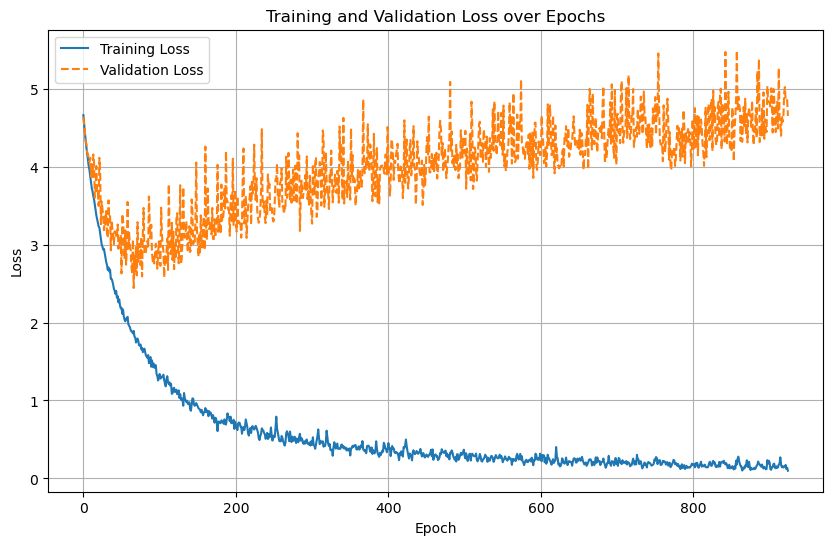

In [17]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Save the trained model
model_filename = 'Latest_WLASL_yesbatchlstm.pth'
torch.save(model.state_dict(), model_filename)
print(f"Model saved as {model_filename}")

Model saved as Latest_WLASL_yesbatchlstm.pth


### Prediction

In [19]:
# Define your custom LSTM model
# class CustomLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(CustomLSTM, self).__init__()
#         self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
#         self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 64)
#         self.fc2 = nn.Linear(64, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 32)
#         self.fc5 = nn.Linear(32, 32)
#         self.output_layer = nn.Linear(32, num_classes)
        
#     def forward(self, x):
#         x, _ = self.lstm1(x)
#         x, _ = self.lstm2(x)
#         x, _ = self.lstm3(x)
#         x = torch.relu(self.fc1(x[:, -1, :]))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         x = torch.relu(self.fc5(x))
#         x = self.output_layer(x)
#         return x

# Define your custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)


        # Fully Connected Layers with BatchNorm
        self.fc1 = nn.Linear(hidden_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.output_layer = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.bn1(self.fc1(x[:, -1, :])))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.relu(self.bn4(self.fc4(x)))
        x = torch.relu(self.bn5(self.fc5(x)))
        x = self.output_layer(x)
        return x
    
# Instantiate the model
input_size = 258
hidden_size = 64
num_classes = len(label_map)
model = CustomLSTM(input_size, hidden_size, num_classes)

# Load the saved model state dictionary
model_filename = 'models/lstm_model_Train_6_0.95.pth'
loaded_model_state_dict = torch.load(model_filename)

# Load the state dictionary into the model
model.load_state_dict(loaded_model_state_dict)
model.eval()  # Set the model to evaluation mode

# # Assuming you have X_test as a NumPy array
X_test_tensor = torch.tensor(X_test_ori, dtype=torch.float32)

# Now you can use the loaded model for prediction
# For example, you can pass your input data (X_test_tensor) through the model
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predicted_classes = test_outputs.argmax(dim=1)

# predicted_classes now contains the predicted class indices for each input in X_test_tensor
print(predicted_classes)

tensor([ 25,  47,  91,   4,  53,   2,  16, 104,  64,   7, 106,  17,   6,  52,
         28,  50,  38,  65,  85,  85,  84,  50,  78,  76,  70,  75,  59,  60,
         88,  12,  28,  95,  37,  35,  74, 104,  81,  14,  47,  60,  62,  79,
         37,  10,  96,  76,  53, 101,  26,  21,  51,  39,  24,  59,  47,  38,
        101,  27,  12,  38,   9,  20,  13,  63,  78,  70,  59,  80,  20,  60,
          8,  34,   6,  31,  33,  39,   0,  90,  86,  76,  67, 103,   9,   1,
         45,  84,  84,  58,  97,   5,  53,  22,  19,   9,  74,  96,  69,   4,
         62,  52,  77,  89,  59,  70,  88,  34,  79,  29,  27, 105,  67,  98,
         55,  81,  11,  27,  70,  94,  26, 100,  16,  75,  74,  49,  54,  44,
         98,  83,  75,   2,  57,  18,  64,  48,  70,  62,   9,  70,  44,  86,
         41,  42,  73,  18,  83,  48,  77,  42, 107,  67,  38,  20,  36,  43,
          5,  23,  85,  61,  70,  63,  13,  80,  93,  79,  57,  92,   7,  39,
          7,  61,  20,  14,  98,  45,  41,  84, 101, 107,  65,  

C:\Users\MCYK\AppData\Local\Temp\ipykernel_30036\3641435393.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_state_dict = torch.load(model_filename)


In [20]:
res = model(X_test_tensor)
pred = res.argmax(dim=1)
print(res[0])
print(pred)

tensor([-20.6711, -15.0049, -17.8475, -10.3949, -28.1612,  -6.5102, -26.8528,
        -16.4200, -19.6451, -17.6335, -17.4343, -10.8070,  -6.2419, -29.2982,
        -38.7323, -13.7285, -15.3808, -23.0805, -21.5870, -18.1558, -13.2202,
         -6.6213,  -8.5532, -12.5264, -21.0996,  13.2605, -38.3898,  -0.9229,
         -9.7857,  -8.3484, -20.7435, -24.3121, -17.1691, -23.4002, -24.0963,
        -25.3504, -27.3765, -17.3172,  -0.8065, -30.3789, -13.4754, -21.3665,
        -11.1741,  -1.9775, -33.8575, -19.8757, -37.6018, -36.1905, -27.1597,
        -25.6644,  -4.9710, -29.2377,  -7.1311,  -6.9981, -12.4423, -10.0828,
        -35.8514, -11.3928, -23.9632, -18.1283, -26.2386,  -7.3527,  -6.4778,
        -17.8398,  -5.3903,  -6.9774, -20.0612, -13.5381, -22.5441, -50.6807,
        -18.6021, -15.6475, -27.6027, -26.4366, -14.3663, -22.5649, -23.6709,
        -17.7311, -21.6066, -10.1564, -12.9361, -17.9291, -19.8837,   1.8127,
        -39.2788, -13.8014, -20.3078, -12.3816, -24.5679, -16.05

In [21]:
# Compare predicted classes with the ground truth labels
for i in range(len(y_test_ori)):
    print(f'Predicted: {gesture_folder[pred[i]]}, Actual: {gesture_folder[y_test_ori[i].argmax()]}')

Predicted: boleh, Actual: boleh
Predicted: kacau, Actual: kacau
Predicted: saudara, Actual: saudara
Predicted: air, Actual: air
Predicted: kereta_api, Actual: masa
Predicted: adik_lelaki, Actual: adik_lelaki
Predicted: bawa, Actual: bawa
Predicted: tidur, Actual: tidur
Predicted: masa, Actual: masa
Predicted: apa, Actual: apa
Predicted: tolong2, Actual: tolong2
Predicted: belajar, Actual: belajar
Predicted: anak, Actual: anak
Predicted: kereta, Actual: kereta
Predicted: buat, Actual: buat
Predicted: kedai, Actual: kedai
Predicted: hilang, Actual: hilang
Predicted: masalah, Actual: masalah
Predicted: perlahan2, Actual: perlahan2
Predicted: perlahan2, Actual: perlahan2
Predicted: perlahan, Actual: perlahan
Predicted: kedai, Actual: kedai
Predicted: payung, Actual: payung
Predicted: pandai, Actual: pandai
Predicted: nama, Actual: nama
Predicted: panas2, Actual: panas2
Predicted: mana, Actual: mana
Predicted: marah, Actual: marah
Predicted: RESET, Actual: RESET
Predicted: bagaimana, Actual

In [22]:
# Test the model prediction
test_accuracy = (predicted_classes == y_test_ori.argmax(axis=1)).float().mean()
print(f'Test Accuracy: {test_accuracy.item():.4f}')


Test Accuracy: 0.9482


In [23]:
def load_keypoints(folder_path):
    """
    Load the keypoints from a given file path.
    
    Parameters:
    path (str): Path to the .npy file containing the keypoints.
    
    Returns:
    list of np.ndarray: List of frames where each frame is a numpy array representing keypoints.
    """
    frames_keypoints = []

    files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    # print(files)

    # arrange files in ascending order
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    print(files)

    # Load the keypoints from the .npy file
    for file in files:
        file_path = os.path.join(folder_path, file)
        frame_keypoints = np.load(file_path)
        frames_keypoints.append(frame_keypoints)

    return frames_keypoints

In [24]:
# %%script false
def normalize_keypoints(input_folder):
    '''
    - pose_keypoints: np.array of shape (33*4,), containing (x, y, z, visibility) for each of the 33 pose keypoints.
    - left_hand_keypoints: Optional, np.array of shape (21*3,), containing (x, y, z) for each of the 21 left hand keypoints.
    - right_hand_keypoints: Optional, np.array of shape (21*3,), containing (x, y, z) for each of the 21 right hand keypoints.
    '''

    # keypoint indices for should and nose
    LEFT_SHOULDER = 11
    RIGHT_SHOULDER = 12
    NOSE = 0

    # Define wrist indices in the hand keypoints
    LEFT_WRIST = 15
    RIGHT_WRIST = 16

    # Results array
    results = []
    
    npy_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.npy')])
    npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    for npy_file in npy_files:
        # load the keypoints
        keypoints = np.load(os.path.join(input_folder, npy_file))
        pose_keypoints = keypoints[:33*4]  # Extract pose keypoints
        left_hand_keypoints = keypoints[33*4:33*4+21*3]   # Extract left hand keypoints
        right_hand_keypoints = keypoints[33*4+21*3:]  # Extract right hand keypoints
        
        # Reshape pose into 33x4 array
        pose_keypoints = pose_keypoints.reshape(33, 4)

        # Extract (x, y) coordinates of the left and right shoulders
        left_shoulder = pose_keypoints[LEFT_SHOULDER, :2] # (x, y)
        right_shoulder = pose_keypoints[RIGHT_SHOULDER, :2] # (x, y)

        # Calculate neck as midpoint between left and right shoulders
        neck = (left_shoulder + right_shoulder) / 2.0

        # Extract (x, y) coordinates of the nose
        head = pose_keypoints[NOSE, :2]

        # Calculate the normalization factor (distance between neck and nose)
        norm_factor = np.linalg.norm(head - neck)

        # Avoid division by zero
        if norm_factor == 0:

            #set norm_factor to 1 if division by zero
            norm_factor = 1
            

        # Normalize pose keypoints (x_k, y_k)
        normalized_pose = np.copy(pose_keypoints)
        for k in range(33):
            normalized_pose[k, :2] = (pose_keypoints[k, :2] - neck) / norm_factor

        # reshape into 21x3 array
        left_hand_keypoints = left_hand_keypoints.reshape(21, 3)
        right_hand_keypoints = right_hand_keypoints.reshape(21, 3)

        # Get wrist coordinates
        left_wrist = pose_keypoints[LEFT_WRIST, :2] # (x, y)
        right_wrist = pose_keypoints[RIGHT_WRIST, :2] # (x, y)

        if np.all(left_hand_keypoints == 0.00000000e+00):
            # print(f"{npy_file} hand keypoints are all zeros")
            normalized_left = np.copy(left_hand_keypoints)
        else:
            normalized_left = np.copy(left_hand_keypoints)
            for k in range(21):
            # Align left hand to left wrist
                normalized_left[k, :2] = (left_hand_keypoints[k, :2] - left_hand_keypoints[0, :2]) / norm_factor + (left_wrist - neck) / norm_factor

        if np.all(right_hand_keypoints == 0.00000000e+00):
            # print(f"{npy_file} hand keypoints are all zeros")
            normalized_right = np.copy(right_hand_keypoints)
        else:
            normalized_right = np.copy(right_hand_keypoints)
            for k in range(21):
            # Align right hand to right wrist
                normalized_right[k, :2] = (right_hand_keypoints[k, :2] - right_hand_keypoints[0, :2]) / norm_factor + (right_wrist - neck) / norm_factor

        # Concatenate normalized pose and hand keypoints
        normalized_keypoints = np.concatenate([normalized_pose.flatten(), normalized_left.flatten(), normalized_right.flatten()])
        results.append(normalized_keypoints)

    # Return the normalized keypoints
    return results

In [25]:
# Test with a single video
# Load a single video

# test = load_keypoints('DATASET/ada/08/landmarks')
test = normalize_keypoints('DATASET/jahat/16/landmarks')
test = np.array(test)
test = np.expand_dims(test, axis=0)
test = torch.tensor(test, dtype=torch.float32)

# Make predictions
with torch.no_grad():
    test_outputs = model(test)
    predicted_class = test_outputs.argmax(dim=1)

# Convert the predicted class index to the corresponding gesture label
predicted_gesture = gesture_folder[predicted_class]
print(predicted_gesture)

jahat


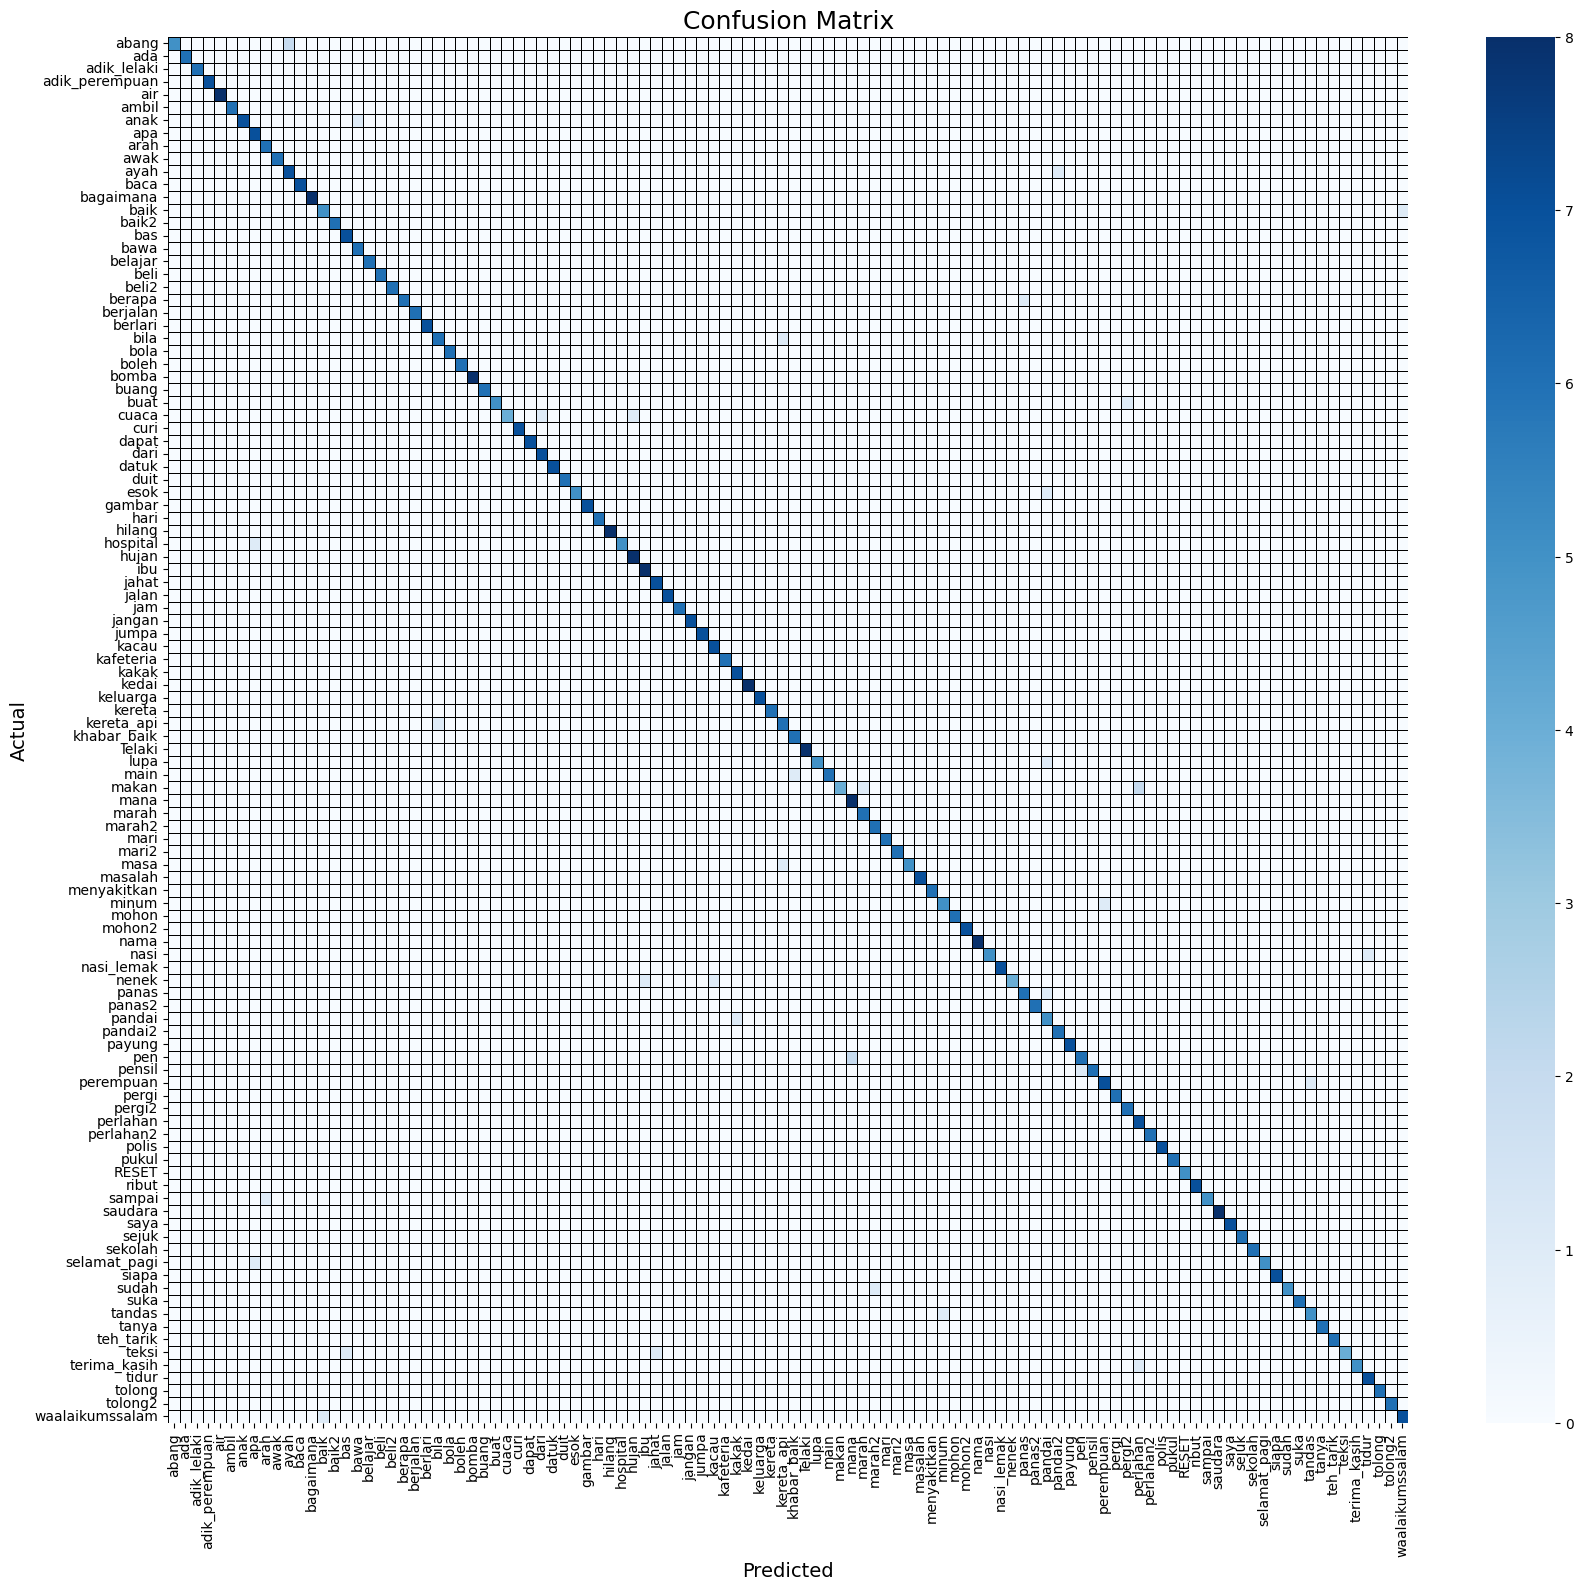

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         6
           6       1.00      0.88      0.93         8
           7       0.78      1.00      0.88         7
           8       0.86      1.00      0.92         6
           9       1.00      1.00      1.00         6
          10       0.78      0.88      0.82         8
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         8
          13       0.83      0.83      0.83         6
          14       1.00      1.00      1.00         6
          15       0.88      1.00      0.93         7
          16       0.86      1.00      0.92         6
    

In [26]:
# Convert one-hot encoded y to class indices if necessary
if len(y.shape) == 2:  # Check for one-hot encoding
    y_true = np.argmax(y_test_ori, axis=1)
else:
    y_true = y  # Already class indices

# Convert PyTorch tensor of predicted classes to NumPy array
y_pred = predicted_classes.numpy()

# Step 3: Generate Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Step 4: Display Confusion Matrix
plt.figure(figsize=(20, 18)) 
sns.heatmap(
    conf_matrix, 
    annot=False, 
    cmap="Blues", 
    xticklabels=list(label_map.keys()), 
    yticklabels=list(label_map.keys()), 
    linecolor='black',  # Grid color
    linewidths=0.5      # Grid line width
)
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better fit
plt.yticks(fontsize=10)  # Adjust font size for y-axis labels
plt.show()

# Step 5: Print Classification Report
print("Classification Report:")
print(class_report)


In [52]:
# %%script false --no-raise-error

label_num = 107

# Reverse the label_map dictionary to get num_to_label
num_to_label = {num: label for label, num in label_map.items()}

# Example: Find the gesture name for a given label number
# label_num = 8 # Replace with the label number you want to look up
gesture_name = num_to_label.get(label_num, "Label not found")

print(gesture_name)

waalaikumssalam


In [ ]:
'''
TRAIN results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.79      1.00      0.88        11
           2       1.00      1.00      1.00        10
           3       0.91      1.00      0.95        10
           4       0.85      0.94      0.89        18
           5       0.45      0.45      0.45        11
           6       1.00      0.96      0.98        25
           7       0.53      0.53      0.53        15
           8       0.60      0.50      0.55        12
           9       0.80      0.50      0.62         8
          10       1.00      0.90      0.95        20
          11       0.75      0.86      0.80        14
          12       0.81      0.81      0.81        16
          13       0.00      0.00      0.00         2
          14       0.70      0.70      0.70        10
          15       1.00      1.00      1.00         8
          16       0.89      0.73      0.80        11
          17       0.91      0.83      0.87        12
          18       0.80      1.00      0.89        12
          19       0.71      0.62      0.67         8
          20       0.00      0.00      0.00         6
          21       0.80      0.57      0.67        14
          22       0.67      0.91      0.77        11
          23       0.80      1.00      0.89        12
          24       0.56      0.64      0.60        14
          25       1.00      1.00      1.00        11
          26       1.00      0.91      0.95        11
          27       0.75      0.75      0.75        16
          28       0.62      0.62      0.62         8
          29       0.91      0.83      0.87        12
          30       0.92      0.92      0.92        12
          31       0.73      1.00      0.84         8
          32       0.75      0.92      0.83        13
          33       0.82      0.64      0.72        14
          34       0.86      1.00      0.92        12
          35       0.83      0.83      0.83        12
          36       0.67      0.77      0.71        13
          37       0.92      0.92      0.92        13
          38       1.00      1.00      1.00        13
          39       0.77      0.71      0.74        24
          40       0.85      0.79      0.81        14
          41       0.94      0.94      0.94        17
          42       0.81      0.81      0.81        21
          43       0.67      0.62      0.64        13
          44       0.72      0.87      0.79        15
          45       0.57      0.73      0.64        11
          46       0.88      0.70      0.78        10
          47       1.00      0.93      0.96        14
          48       0.75      0.75      0.75        12
          49       1.00      0.92      0.96        12
          50       1.00      0.93      0.97        15
          51       0.71      1.00      0.83        17
          52       1.00      0.87      0.93        15
          53       1.00      0.80      0.89        10
          54       0.93      0.93      0.93        15
          55       0.88      0.78      0.82         9
          56       1.00      0.95      0.97        19
          57       1.00      0.92      0.96        12
          58       0.83      0.50      0.62        10
          59       0.90      0.69      0.78        13
          60       0.59      0.80      0.68        20
          61       1.00      0.67      0.80         9
          62       1.00      0.88      0.93         8
          63       0.60      0.75      0.67        12
          64       1.00      1.00      1.00         5
          65       0.77      0.83      0.80        12
          66       1.00      1.00      1.00        14
          67       0.67      0.50      0.57         8
          68       1.00      0.80      0.89        10
          69       0.78      0.58      0.67        12
          70       0.89      1.00      0.94         8
          71       0.90      0.95      0.93        20
          72       0.65      1.00      0.79        11
          73       0.92      1.00      0.96        11
          74       0.82      0.90      0.86        10
          75       0.55      0.85      0.67        13
          76       0.73      0.80      0.76        10
          77       0.92      0.92      0.92        12
          78       0.80      0.73      0.76        11
          79       1.00      0.79      0.88        14
          80       0.57      0.81      0.67        21
          81       0.78      0.70      0.74        10
          82       0.74      0.71      0.72        24
          83       1.00      0.11      0.20         9
          84       0.78      0.88      0.82         8
          85       1.00      0.85      0.92        13
          86       0.54      0.58      0.56        12
          87       1.00      0.83      0.91        12
          88       0.76      0.93      0.84        14
          89       1.00      0.33      0.50         6
          90       1.00      0.92      0.96        13
          91       0.89      0.67      0.76        12
          92       0.72      0.81      0.76        16
          93       0.92      0.86      0.89        14
          94       0.92      0.92      0.92        12
          95       1.00      0.71      0.83        14
          96       1.00      0.78      0.88         9
          97       0.86      0.80      0.83        15
          98       0.50      0.44      0.47         9
          99       0.56      0.50      0.53        10
         100       0.60      0.92      0.73        13
         101       0.75      0.75      0.75        12
         102       1.00      0.56      0.71         9
         103       0.50      0.40      0.44        10
         104       0.64      0.75      0.69        12
         105       1.00      0.78      0.88         9
         106       0.70      0.70      0.70        10
         107       0.22      0.33      0.27         6
         108       0.64      0.50      0.56        18

    accuracy                           0.80      1352
   macro avg       0.80      0.77      0.78      1352
weighted avg       0.81      0.80      0.79      1352
'''

'\nTRAIN results:\nClassification Report:\n              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        14\n           1       0.79      1.00      0.88        11\n           2       1.00      1.00      1.00        10\n           3       0.91      1.00      0.95        10\n           4       0.85      0.94      0.89        18\n           5       0.45      0.45      0.45        11\n           6       1.00      0.96      0.98        25\n           7       0.53      0.53      0.53        15\n           8       0.60      0.50      0.55        12\n           9       0.80      0.50      0.62         8\n          10       1.00      0.90      0.95        20\n          11       0.75      0.86      0.80        14\n          12       0.81      0.81      0.81        16\n          13       0.00      0.00      0.00         2\n          14       0.70      0.70      0.70        10\n          15       1.00      1.00      1.00         8\n          16       0